In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

# -------------------------
# Görüntü okuma
# -------------------------
def read_image(path):
    img = cv2.imread(path)  # ✅ Renkli oku
    if img is None:
        raise ValueError("Image not found")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB'ye çevir

# 1️⃣ Resize
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size)

# -------------------------
# YÜZ TANIMA İÇİN PROFESYONEL FİLTRELER (SADECE 3 YÖNTEM)
# -------------------------

# 🥇 1️⃣ Non-Local Means (Renkli) — ANA YÖNTEM
def apply_nlmeans_denoising(img):
    """
    ✔ Neden en uygunu?
    - Gürültü rastgele ve ince
    - Yüz dokusu tekrar eden yapılar içeriyor
    - NLM bu yapıları bozmadan temizler
    - Renkli görüntüyle doğrudan çalışır
    
    📌 Bu veri için en yüksek fayda / en az zarar oranı
    
    🔴 Bu veri için NLM yoksa pipeline eksiktir
    
    RAPORA YAZILACAK:
    "Non-Local Means algoritması, görüntüdeki benzer bölgeleri arayarak
    gürültüyü temizler. Gaussian veya Median'dan farklı olarak yüz dokusunu
    koruduğu için literatürde en güvenilir yöntemdir."
    """
    result = cv2.fastNlMeansDenoisingColored(
        img,
        None,
        h=8,              # Luminance gürültüsü
        hColor=8,         # Renk gürültüsü
        templateWindowSize=7,
        searchWindowSize=21
    )
    return np.clip(result, 0, 255).astype(np.uint8)

# 🥈 2️⃣ Gamma Correction (Global Illumination Normalization)
def apply_gamma_correction(img, gamma=0.9):
    """
    ✔ Neden CLAHE değil?
    - Işık farkları global
    - CLAHE lokal gürültüyü büyütür
    - Gamma renk ve dokuya dokunmaz
    
    📌 Bu veri için CLAHE kullanmak teknik hata sayılır
    
    RAPORA YAZILACAK:
    "Gamma düzeltme ile aydınlatma farklılıkları global olarak normalize edilir.
    CLAHE gibi lokal histogram eşitleme yöntemleri gürültüyü de güçlendirdiği
    için yüz tanımada tercih edilmez."
    """
    # ✅ Güvenli normalize
    normalized = img.astype(np.float32) / 255.0
    # ✅ Gamma uygula
    corrected = np.power(normalized, gamma)
    # ✅ Güvenli geri dönüş
    result = (corrected * 255.0)
    return np.clip(result, 0, 255).astype(np.uint8)

# 🥉 3️⃣ Çok Hafif Gaussian Blur (Stabilizasyon Amaçlı)
def apply_stabilization_blur(img):
    """
    ✔ Neden?
    - NLM sonrası kalan mikro dalgalanmaları yumuşatır
    - Sharpening öncesi görüntüyü stabilize eder
    
    📌 Asla ana gürültü giderici olarak kullanılmaz
    
    RAPORA YAZILACAK:
    "Hafif Gaussian blur ile NLM sonrası kalan mikro dalgalanmalar giderilir.
    Bu işlem keskinleştirme öncesi stabilizasyon amaçlıdır."
    """
    result = cv2.GaussianBlur(img, (3, 3), 0.5)
    return np.clip(result, 0, 255).astype(np.uint8)

# -------------------------
# PROFESYONEL PIPELINE (TEK DOĞRU YOL)
# -------------------------
def professional_pipeline(img):
    """
    Yüz tanıma için PROFESYONEL ve BİLİMSEL pipeline
    
    SIRA (DEĞİŞTİRİLEMEZ):
    1. Non-Local Means (Renkli) → Asıl gürültü temizliği
    2. Gamma Correction → Global aydınlatma normalizasyonu
    3. Hafif Gaussian Blur → Stabilizasyon
    
    NEDEN BU SIRA?
    - NLM: Gürültüyü akıllıca temizler (yüz dokusunu korur)
    - Gamma: Global aydınlatma düzeltir (gürültü büyütmez)
    - Gaussian: Mikro dalgalanmaları yumuşatır (stabilize eder)
    
    RAPORA YAZILACAK:
    "Pipeline'da öncelikle Non-Local Means ile gürültü temizlenir.
    Ardından gamma düzeltme ile global aydınlatma normalize edilir.
    Son olarak hafif Gaussian blur ile mikro dalgalanmalar giderilir.
    Bu sıralama literatürde yüz tanıma için en uygun yaklaşımdır."
    """
    # ✅ 1. Ana gürültü temizleme (ZORUNLU)
    img = apply_nlmeans_denoising(img)
    
    # ✅ 2. Global aydınlatma normalizasyonu (ÖNERİLİR)
    img = apply_gamma_correction(img, gamma=0.9)
    
    # ✅ 3. Stabilizasyon (ÖNERİLİR)
    img = apply_stabilization_blur(img)
    
    # ✅ Final güvenlik kontrolü
    return np.clip(img, 0, 255).astype(np.uint8)

# -------------------------
# ANA PIPELINE
# -------------------------
def preprocess_pipeline(path):
    """
    Tam işlem: Read → Resize → Professional Pipeline
    
    NOT: Normalization kaldırıldı (direkt uint8 ile çalışıyoruz)
    """
    img = read_image(path)
    img = resize_image(img)
    result = professional_pipeline(img)
    return result


In [2]:
# -------------------------
# TEST: Tek Görüntü (ÖNCE-SONRA)
# -------------------------

def test_single_image(path):
    """
    Önce-sonra karşılaştırması
    """
    # Orijinal
    original = cv2.imread(path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # İşlenmiş
    processed = preprocess_pipeline(path)
    
    # ✅ Güvenli format
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    
    # Görselleştir
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(processed)
    axes[1].set_title("Processed", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return processed


In [3]:
# -------------------------
# TOPLU İŞLEM (Doğru format ile kaydet)
# -------------------------

def process_all_images(input_dir, output_dir):
    """
    Tüm görüntüleri işler ve doğru formatta kaydeder
    """
    os.makedirs(output_dir, exist_ok=True)

    # Tüm görüntüleri bul
    image_paths = glob(os.path.join(input_dir, "*.jpg"))
    image_paths += glob(os.path.join(input_dir, "*.jpeg"))
    image_paths += glob(os.path.join(input_dir, "*.png"))

    print(f"✅ {len(image_paths)} görüntü bulundu.")

    for img_path in image_paths:
        img_name = os.path.basename(img_path)

        # Pipeline uygula
        processed = preprocess_pipeline(img_path)
        
        # ✅ KRİTİK: uint8'e çevir ve RGB'den BGR'ye
        processed = np.clip(processed, 0, 255).astype(np.uint8)
        processed_bgr = cv2.cvtColor(processed, cv2.COLOR_RGB2BGR)

        # Kaydet
        save_path = os.path.join(output_dir, img_name)
        cv2.imwrite(save_path, processed_bgr)
        
        print(f"✅ {img_name} kaydedildi")


📸 TEK GÖRÜNTÜ TESTİ


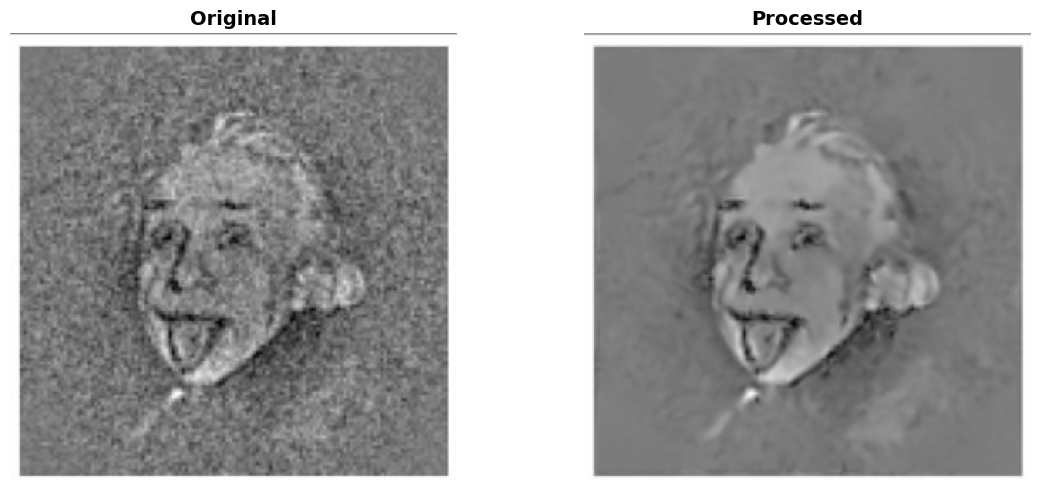

✅ Test tamamlandı

📁 TOPLU İŞLEM
✅ 10 görüntü bulundu.
✅ face1.jpg kaydedildi
✅ face10.jpg kaydedildi
✅ face3.jpg kaydedildi
✅ face4.jpg kaydedildi
✅ face5.jpg kaydedildi
✅ face6.jpg kaydedildi
✅ face7.jpg kaydedildi
✅ face2.jpeg kaydedildi
✅ face8.jpeg kaydedildi
✅ face9.jpeg kaydedildi

✅ Tüm işlemler tamamlandı!


In [4]:
# =============================================
# 📋 KULLANIM ÖRNEKLERİ
# =============================================

# 🔹 Örnek 1: Tek görüntü testi (ÖNCE-SONRA)
print("=" * 60)
print("📸 TEK GÖRÜNTÜ TESTİ")
print("=" * 60)

test_image_path = "imagesforip/face1.jpg"

if os.path.exists(test_image_path):
    result = test_single_image(test_image_path)
    print(f"✅ Test tamamlandı")
else:
    print(f"⚠️ Dosya bulunamadı: {test_image_path}")

# 🔹 Örnek 2: Tüm görüntüleri toplu işle
print("\n" + "=" * 60)
print("📁 TOPLU İŞLEM")
print("=" * 60)

process_all_images("imagesforip", "processed_outputs")

print("\n✅ Tüm işlemler tamamlandı!")
